## The Wonderful World of ML - Session 6: Data Wrangling in R - Part 1

### Why focus on data wrangling?

In the first of these sessions, we jumped right into a few of the basic ML algorithms: linear regresssion, logistic regression, LDA, QDA, and decision trees.  In this session we'll step back and look at data wrangling.  It's an important topic because in my experience and as what the literature suggests [[1]](https://www.jstatsoft.org/article/view/v059i10/v59i10.pdf), is that it consumes roughly 80% of the time spent doing an analysis.

If it takes this much time just to get the data in a usable form, it makes sense to spend a little time in building some skills in this area.




In [2]:
data_path <- "https://raw.githubusercontent.com/MichaelSzczepaniak/WonderfulML/master/data/broncos2016.csv"
broncos_data <- read.csv(data_path)
head(broncos_data)
logRegBroncos <- glm(broncos_data$DenWin ~ broncos_data$DenScore, family="binomial")
summary(logRegBroncos)

Date,Week,DenScore,OppScore,DenWin,Home,Off1stDwns,OffPassYrds,OffRushYrds,Def1stDwns,DefPassYrds,DefRushYrds,Notes
09/08/2016,1,21,20,1,1,21,159,148,21,176,157,
09/18/2016,2,34,20,1,1,24,266,134,19,170,83,
09/25/2016,3,29,17,1,0,21,303,52,20,189,143,
10/02/2016,4,27,7,1,0,22,218,89,15,143,72,
10/09/2016,5,16,23,0,1,18,183,84,19,250,122,
10/13/2016,6,13,21,0,0,16,220,84,16,166,99,



Call:
glm(formula = broncos_data$DenWin ~ broncos_data$DenScore, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1947  -0.2699   0.2206   0.4761   1.2306  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)  
(Intercept)            -7.0906     3.7653  -1.883   0.0597 .
broncos_data$DenScore   0.3483     0.1702   2.047   0.0407 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 21.930  on 15  degrees of freedom
Residual deviance: 10.965  on 14  degrees of freedom
AIC: 14.965

Number of Fisher Scoring iterations: 6


In [3]:
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library(stats)))
suppressMessages(suppressWarnings(library(base)))
suppressMessages(suppressWarnings(library(bindrcpp)))

library(dplyr)

broncos_data <- mutate(broncos_data, Delta1stDwns = Off1stDwns - Def1stDwns)
broncos_data <- mutate(broncos_data, YrdsOffTotal = OffPassYrds + OffRushYrds)
broncos_data <- mutate(broncos_data, YrdsDefTotal = DefPassYrds + DefRushYrds)
broncos_data <- mutate(broncos_data, YrdsDiff = YrdsOffTotal - YrdsDefTotal)
#broncos_data[, c('DenWin', 'YrdsDiff')]
#broncos_data
logRegBroncos3 <- glm(broncos_data$DenWin ~ broncos_data$DenScore + broncos_data$YrdsDiff, family="binomial")
summary(logRegBroncos3)


Call:
glm(formula = broncos_data$DenWin ~ broncos_data$DenScore + broncos_data$YrdsDiff, 
    family = "binomial")

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.49668  -0.07598   0.07638   0.35998   1.35019  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)
(Intercept)           -15.94706   10.46565  -1.524    0.128
broncos_data$DenScore   0.74469    0.47232   1.577    0.115
broncos_data$YrdsDiff  -0.01815    0.01417  -1.281    0.200

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 21.9301  on 15  degrees of freedom
Residual deviance:  8.6284  on 13  degrees of freedom
AIC: 14.628

Number of Fisher Scoring iterations: 7


Adding **YrdsDiff** is not significantly zero at 95% confidence, but the AIC is a little lower.  AIC is proxy for test error, so it suggests that **logRegBroncos3** might be slightly better than **logRegBroncos**.

### Problem 2 - Add an L2 Weight Penalty

In session 3, we discussed how we could employ shrinkage methods to lower our risk of overfitting.  Specifically, we discussed the effects of applying L1 (lasso) and L2 (ridge) penalties to regression models.  What we did not discuss, was that you can apply them to classification.  The basic motivation behind applying these methods for classification are similar to those behind applying them for regression: We want to minimize overfitting.

These 2 videos (in the repo) from the University of Washington's [**Machine Learning: Classification** class on coursera](https://www.coursera.org/learn/ml-classification/home/welcome) (requires an account on coursera) do a really nice job of describing why and how to apply an L2 weight penalty to a logistic regression model:

+ [Penalizing large coefficients to mitigate overfitting](https://github.com/MichaelSzczepaniak/WonderfulML/raw/master/docs/resources/010%20-%20Penalizing%20large%20coefficients%20to%20mitigate%20overfitting.mp4)
+ [L2 Regularized Logistic Regression](https://github.com/MichaelSzczepaniak/WonderfulML/raw/master/docs/resources/011%20-%20L2%20regularized%20logistic%20regression.mp4)

Let's see how an L2 weight penalty can help us.  Try this task:

1) Read in this cleaned and truncated version of the [Titanic data set](https://raw.githubusercontent.com/MichaelSzczepaniak/WonderfulML/master/data/titanic_class_sex_age.csv).  A description of the data can be found in the [Data Dictionary section of this document](https://github.com/MichaelSzczepaniak/Jamatitanic/blob/master/data/titanic%20data%20dictionary.pdf).  After the read, split the data into 3 partitions: 400 training sample, 200 test sample, and 114 validation samples.  Use the code provided below to get started.

2) Using just the training set, fit a logistic regression model starting with **Pclass** then adding **Age** and **Sex** if they are significantly non-zero and improve AIC.  What does an improvement in AIC look like (increase or decrease)? Why?

3) Use the training and validation set to determine which of these 10 values of L2 weight penalty $\lambda$ minimizes the negative log-likelihood cost function (same as maximizing the log-likelihood).  Use the following algorithm:


In [4]:
data_all <- read.csv("https://raw.githubusercontent.com/MichaelSzczepaniak/WonderfulML/master/data/titanic_class_sex_age.csv", na.strings = c("NA", ""), stringsAsFactors = FALSE)
data_all <- data_all[, c('PassengerId','Survived', 'Pclass', 'Name', 'Sex', 'Age')]
head(data_all)

PassengerId,Survived,Pclass,Name,Sex,Age
1,0,3,"Braund, Mr. Owen Harris",male,22
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38
3,1,3,"Heikkinen, Miss. Laina",female,26
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35
5,0,3,"Allen, Mr. William Henry",male,35
7,0,1,"McCarthy, Mr. Timothy J",male,54


In [5]:
suppressMessages(suppressWarnings(library(caret)))
suppressMessages(suppressWarnings(library(lattice)))
suppressMessages(suppressWarnings(library(ggplot2)))
suppressMessages(suppressWarnings(library(e1071)))

library(caret)
library(e1071)
set.seed(711)

# Factorize the discrete variables
data_all$Survived <- factor(data_all$Survived)
data_all$Sex <- factor(data_all$Sex)
data_all$Pclass <- factor(data_all$Pclass)

# Create training, validation, and test datasets
train_test_indices <- sample(1:nrow(data_all), 600)
valid_data <- data_all[-train_test_indices, ]     # 714 - 600 = 114 validation samples
train_indices <- sample(train_test_indices, 400)  # 400 train samples
test_indices <- setdiff(train_test_indices, train_indices)
train_data <- data_all[train_indices, ]
test_data <- data_all[test_indices, ]             # 200 test samples
# Check: If train, test, and validation are disjoint, id_keys should have nrow(data_all) = 714 rows
id_keys <- union(union(train_data$PassengerId, test_data$PassengerId), valid_data$PassengerId)
c(nrow(train_data), nrow(test_data), nrow(valid_data), length(id_keys))

[1] 400 200 114 714

In [6]:
titanic_mod1 <- glm(Survived ~ Pclass, data=train_data, family="binomial")
summary(titanic_mod1)


Call:
glm(formula = Survived ~ Pclass, family = "binomial", data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4028  -0.7059  -0.7059   0.9860   1.7389  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.5158     0.1998   2.581  0.00984 ** 
Pclass2      -0.1863     0.2861  -0.651  0.51488    
Pclass3      -1.7785     0.2641  -6.734 1.65e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 543.58  on 399  degrees of freedom
Residual deviance: 480.43  on 397  degrees of freedom
AIC: 486.43

Number of Fisher Scoring iterations: 4


Significance of the intercept and **Pclass** slope look good.  Let's add **Age** and see what happens.

In [7]:
titanic_mod2 <- glm(Survived ~ Pclass + Age, data=train_data, family="binomial")
summary(titanic_mod2)


Call:
glm(formula = Survived ~ Pclass + Age, family = "binomial", data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1395  -0.8144  -0.5592   0.9203   2.4766  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.270464   0.419155   5.417 6.07e-08 ***
Pclass2     -0.520854   0.308600  -1.688   0.0915 .  
Pclass3     -2.493670   0.321131  -7.765 8.15e-15 ***
Age         -0.044378   0.008941  -4.963 6.92e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 543.58  on 399  degrees of freedom
Residual deviance: 452.79  on 396  degrees of freedom
AIC: 460.79

Number of Fisher Scoring iterations: 3


All parameters appear significant and we got a small reduction in AIC, so it looks like we are going in the right direction.  Let's add our last parameter **Sex** and see what happens.

In [8]:
titanic_mod3 <- glm(Survived ~ Pclass + Age + Sex, data=train_data, family="binomial")
summary(titanic_mod3)


Call:
glm(formula = Survived ~ Pclass + Age + Sex, family = "binomial", 
    data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7544  -0.6141  -0.3442   0.5282   2.5527  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.84730    0.54922   7.005 2.47e-12 ***
Pclass2     -0.74882    0.37871  -1.977 0.048009 *  
Pclass3     -2.54751    0.38901  -6.549 5.80e-11 ***
Age         -0.03838    0.01034  -3.712 0.000206 ***
Sexmale     -2.83001    0.29192  -9.695  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 543.58  on 399  degrees of freedom
Residual deviance: 333.29  on 395  degrees of freedom
AIC: 343.29

Number of Fisher Scoring iterations: 5


All parameters are still significant and we got an even bigger reduction in AIC, so let's see how this model does on the validation set.

In [9]:
# retrain using caret interface for easier evaluation
titanic_mod3 <- train(Survived ~ Pclass + Age + Sex, method='glm', data=train_data, family="binomial")
mod3_valid_results <- predict(titanic_mod3, newdata=valid_data)
mod3_valid_acc <- sum(mod3_valid_results == valid_data$Survived) / nrow(valid_data)
mod3_valid_acc

[1] 0.8157895

Not too bad, now let's implement an L2 weight penalty.  **TODO** see references below:

+ [glmnet vignette on CRAN](https://cran.r-project.org/web/packages/penalized/vignettes/penalized.pdf)
+ [https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html#log](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html#log)
+ [nice roll-your-own logistic regression example in R]{https://www.r-bloggers.com/logistic-regression-regularized-with-optimization/)

To see an implementation of ridge regression (L2 weight penalty) applied to a regression problem, refer to an [analysis on the abalone dataset done here](https://github.com/MichaelSzczepaniak/WonderfulML/raw/master/docs/resources/abalone_regression_analysis.pdf).

$$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\betav}{\mathbf{\beta}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\grad}{\mathbf{\nabla}}
\newcommand{\ebx}[1]{e^{\wv_{#1}^T \xv_n}}
\newcommand{\eby}[1]{e^{y_{n,#1}}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Fv}{\mathbf{F}}
\newcommand{\ones}[1]{\mathbf{1}_{#1}}
$$

## The Wonderful World of ML - Session 4 Discussion: 
## Linear & Quadratic Discriminant Analysis (LDA & QDA)

In logistic regression, we were fitting a function directly to our probablity of a certain class given the data or $P(C_n=k\,|\, \xv_n)$ where $C_n=\text{class of } n^\text{th}\text{ sample}$.  In LDA and QDA, we do something a little different.  We start by modeling the likelihood of the data within each class or $P(\xv_n\,|\, C=k)$ and then use Bayes' Theorem (shown below) to compute the probability of a certain class given that data or $P(C_n=k\,|\, \xv_n)$.

(1)$$
	P(C=k|x) = \frac{P(x|C=k) P(C=k)}{P(x)}
$$

This seems a little cumbersome doesn't it?  Can you think of any reasons why we would want to do this?

Well, if we think about this a little, we might realize that we typically can observe how the data is distributed within a class (sometimes referred to as "the likelihood of the data") which is the $p(\xv_n\,|\, C=k)$ term.  We might then conclude that it is natural to use these distributions within each class to infer the actual class from the data.

In order to make use of (1), we need to make a important assumption about the probability distribution of a data sample from each class to define $P(\xv_n\,|\, C=k)$.  A common assumption is that this distribution is Normal with mean $\mu_k$ and covariance matrix $\Sigma_k$.  This assumption allows $P(\xv_n\,|\, C=k)$ to be expressed using the common relationship for the d-dimensional Guassian distribution as shown in equation (2).

(2)$$
P(x|C=k) = \frac{1}{(2\pi)^{\frac{p}{2}} |\Sigma_k|^{\frac{1}{2}}}
e^{-\frac{1}{2}(x-\mu_k)^T \Sigma_k^{-1} (x-\mu_k)}
$$

To classify $x$ as being from Class 1 in a two-class discrimination problem, we must check to see if  $P(C=1 | x) > P(C=2 | x)$ is true.  Rewriting each side of the inequality using Bayes' Theorem we get equation (3).

(3)$$
P(x|C=1) P(C=1) / P(x) > P(x|C=2)P(C=2)/P(x)
$$

Since $P(x)$ is positive, it can be removed from each side.  And since we have defined $P(x|C=k)$ to be a Normal distribution involving an exponential, we can take the logarithm and expand both sides as shown in equations (4) and (5).

(4)$$
\log( P(x|C=1) P(C=1)) > \log( P(x|C=2) P(C=2))
$$

(5)$$
\log( P(x|C=1)) + \log( P(C=1)) > \log( P(x|C=2)) + \log( P(C=2))
$$

If we substitute equation (2) into (5) and simplify, the left side of the inequality would look like what is shown in (6) and the right side would look like what is shown in (7).

(6)$$
-\frac{1}{2} \log |\Sigma_1| -\frac{1}{2}(x-\mu_1)^T \Sigma_1^{-1} (x-\mu_1) + \log P(C=1)
$$

(7)$$
-\frac{1}{2} \log |\Sigma_2| -\frac{1}{2}(x-\mu_2)^T \Sigma_2^{-1} (x-\mu_2) + \log P(C=2)
$$

If we define each side of this inequality as a discriminant function, $\delta(x)$ for
Class 1 or 2, then, in general

(8)$$
\delta_k(x) = -\frac{1}{2} \log |\Sigma_k| -\frac{1}{2}(x-\mu_k)^T
\Sigma_k^{-1} (x-\mu_k) + \log P(C=k)
$$

and the class of a new sample $x$ is $argmax_k \delta_k(x)$.  Notice
that the boundary between Class 1 and Class 2 is the set of points $x$
for which $\delta_1(x) = \delta_2(x)$.  Substituting in the definitions of these discriminant functions we see that this equation is quadratic in $x$, meaning that the boundary between Class 1 and 2 is quadratic.  We have just defined **Quadratic Discriminant Analysis**, or **QDA**.  

In order to apply QDA to a given sets of data samples $X_1, X_2, \ldots, X_K$ from Classes $1, 2, \dots, K$, we must compute the likelihood and prior terms: $P(x|C=k)$ and $P(C=k)$ respectively, using (9), (10), and (11):

(9)$$
\mu_k = \frac{1}{N_k} \sum_{x \in X_k} x
$$

(10)$$
\Sigma_k = \frac{1}{N_k-1} \sum_{x\in X_k} (x-\mu_k) (x-\mu_k)^T
$$

(11)$$
P(C=k) = \frac{N_k}{N}
$$

where $N_k$ is the number of samples in $X_k$ and $N$ is the number of all samples.

### Linear Discriminant Analysis (LDA)

LDA is derived in the same way as QDA with the additional assumption that the variance within each class are equal.  Making this additional assumption allows us to simplify the terms in (6) and (7) defined on both sides inequality as shown in equation (12).

(12)$$
x^T \Sigma^{-1} \mu_1 - \frac{1}{2}\mu_1^T \Sigma^{-1} \mu_1 + \log P(C=1) >
x^T \Sigma^{-1} \mu_2 - \frac{1}{2}\mu_2^T \Sigma^{-1} \mu_2 + \log P(C=2)
$$

which results in the new discriminant defined in equation (13) which is the same as equation (4.19) in the ESL.

(13)$$
\delta_k(x) = x^T \Sigma^{-1} \mu_k - \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k + \log P(C=k)
$$

where the new effectively averaged covariance matrix is defined by (14).

(14)$$
\Sigma = \frac{1}{N-K} \sum_{k=1}^K \sum_{x\in X_k}(x-\mu_k)(x-\mu_k)^T
$$

Like QDA, the maximum $\delta_k(x)$ for a given $x$ determines the class.

Let's implement QDA and LDA on some 1 and 2-D sythetic data for illustration purposes.  After that, we'll take them for a spin on [an interesting real data set](http://archive.ics.uci.edu/ml/datasets/heart+Disease).  Let's start with QDA on 1-D data.

### 1-D QDA & LDA Visualizations On Synthetic Data

#### QDA On 1-D Data

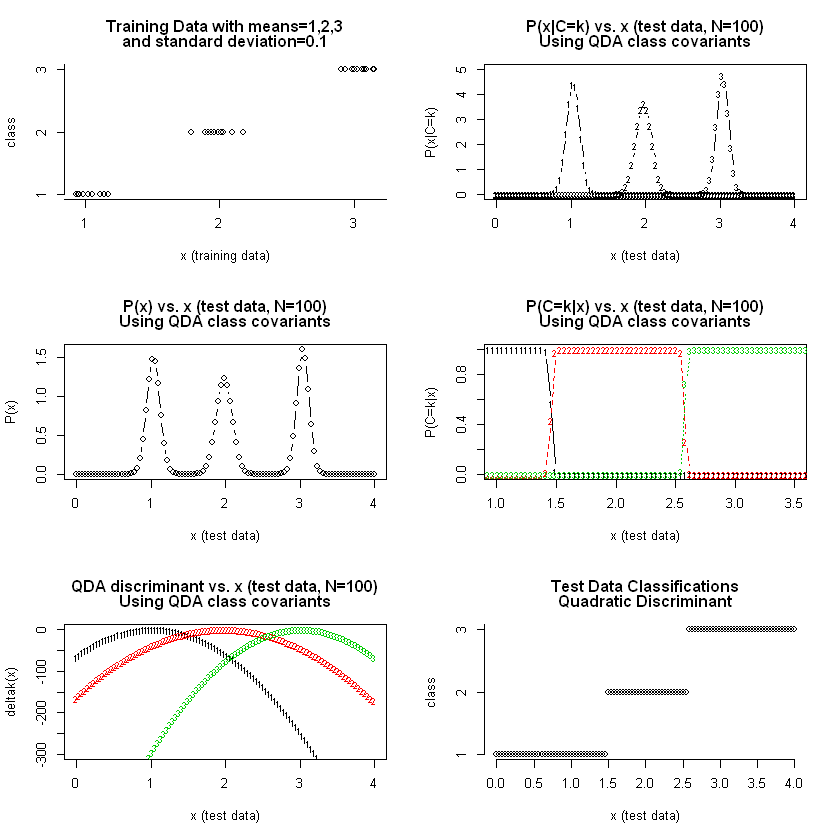

In [10]:
# The following functions live in QdaLda.R:
# priorPofC, classMeans, classCovars, mydnormm, deltQda, deltLda (used in the next section)
source('../../R/QdaLda.R')  # assumes notebook running in ../WonderfulML/docs/solutions

# Creates and returns a (nc * 10) x 2 matrix where nc = number of classes,
# ms = the mean of the 1-D dataset, stds = std. deviation of the 1-D
# data set.
getData1D <- function(nc, ms, stds, seed=711) {
    set.seed(seed)
    data <- NULL

    # create the data to classify
    for (class in 1:nc) {
        data <- rbind(data, cbind(rep(class, 10), rnorm(10,ms[class],stds)))
    }
    colnames(data) <- c("class", "sample")

    return(data)
}

plot1D_Training <- function(dat) {
    plt <- plot(dat[,2],dat[,1],xlab="x (training data)",ylab="class",
    main=c("Training Data with means=1,2,3",
           "and standard deviation=0.1"), axes=FALSE)
    axis(1, seq(0,4,by=1.0))
    axis(2, 1:4)
    
    return(plt)
}

# Creates a 3x2 panel of plots for the result of QDA on 1D synthetic data
plotQda_1d <- function(class_means=c(1, 2, 3), class_stdevs=c(0.1, 0.1, 0.1)) {
    # generate 3x2 plots for QDA evaluation
    par(mfrow=c(3, 2))  # adjust as plots are added
    # generate and plot 1-D training data
    nclass <- length(class_means)
    xtrain <- getData1D(nclass, class_means, class_stdevs)
    plot1D_Training(xtrain)  # upper left of plot of training data

    # generate sample 1-D test data
    xtest <- matrix(seq(0,4,len=100),100,1)
    Ntest <- length(xtest)
    
    # compute priors, class means, and class covariance matrices
    pc <- priorPofC(xtrain)
    muk <- classMeans(xtrain)
    var <- classCovars(xtrain, muk) 

    # calc & plot P(x|C=k) vs. x, start by eval'ing the first class
    pxc <- xtest
    pxc <- cbind(pxc, mydnormm(xtest, muk[1,], var[[1]]))
    colnames(pxc)[] <- c("x", "pxc 1")
    plot(pxc[,1], pxc[,2], type="b", xlim=c(0,4), ylim=c(0,5),
         pch=paste(1), cex=0.7, main=c("P(x|C=k) vs. x (test data, N=100)",
         "Using QDA class covariants"),
         xlab="x (test data)", ylab="P(x|C=k)")
    
    # now evaluate the remaining classes
    for(class in 2:nclass){
      #pxc <- cbind(pxc, data[which(data[,1]==class),2])
      pcalcs <- mydnormm(xtest, muk[class,], var[[class]])
      pxc <- cbind(pxc, pcalcs)
      colnames(pxc)[ncol(pxc)] <- paste("pxc", class)
      points(pxc[,1],pxc[,class+1], type="b",
             pch=paste(class), cex=0.7)
    }
    
    # calc & plot P(x) vs. x
    ptable <- cbind(pxc, rep(0,Ntest))  # init P(x) in last col
    pxcol <- ncol(ptable)               # set up P(x) column of values
    colnames(ptable)[pxcol] <- "pofx"
    for(class in 1:nclass)
      ptable[,pxcol] <- ptable[,pxcol]+(pxc[,class+1]*pc[class])

    plot(ptable[,1],ptable[,pxcol], type="b",
        main=c("P(x) vs. x (test data, N=100)",
               "Using QDA class covariants"),
               xlab="x (test data)", ylab="P(x)")

    # calc & plot P(C|x) vs. x
    for(class in 1:nclass) {
      pcx <- ptable[,class+1] * pc[class] / ptable[,nclass+2]
      ptable <- cbind(ptable, pcx)
      colnames(ptable)[ncol(ptable)] <- paste("pcx", class)
    }
    pcx1col <- nclass + 3  # 1st 3 col's in ptable: P(X|C=1), P(X|C=2), P(X)
    pcxkcol <- pcx1col + (nclass - 1)  # col index for P(X|C=k) for k > 1
    matplot(ptable[,1],ptable[,pcx1col:pcxkcol], type="b", cex=0.7,
            main=c("P(C=k|x) vs. x (test data, N=100)",
            "Using QDA class covariants"),
            xlim=c(1, 3.5), xlab="x (test data)", ylab="P(C=k|x)")
        
    # calc & plot little delta(x) QDA disciminant vs. x
    dx <- deltQda(xtest, Ntest, nclass, pc, muk, var)
    dx <- cbind(xtest,dx)
    matplot(dx[,1], dx[,2:ncol(dx)], ylim=c(-300,0), cex=0.7,
            main=c("QDA discriminant vs. x (test data, N=100)",
            "Using QDA class covariants"),
            xlab="x (test data)", ylab="deltak(x)")

    # do the QDA classification and plot the results
    classif <- dx
    classif <- cbind(classif, rep(0,nrow(classif)))
    colnames(classif) <- c("x", paste("dx", 1:nclass), "class")
    for(rw in 1:nrow(classif))
      classif[rw,ncol(classif)] <- which.max(classif[rw,2:(ncol(classif)-1)])

    plot(classif[,1],classif[,ncol(classif)],
        xlab="x (test data)",ylab="class",
        main=c("Test Data Classifications",
        "Quadratic Discriminant"), axes=FALSE)
    axis(1, seq(0,4,by=0.5))
    axis(2, 1:4)
}

plotQda_1d()

#### LDA On 1-D Data

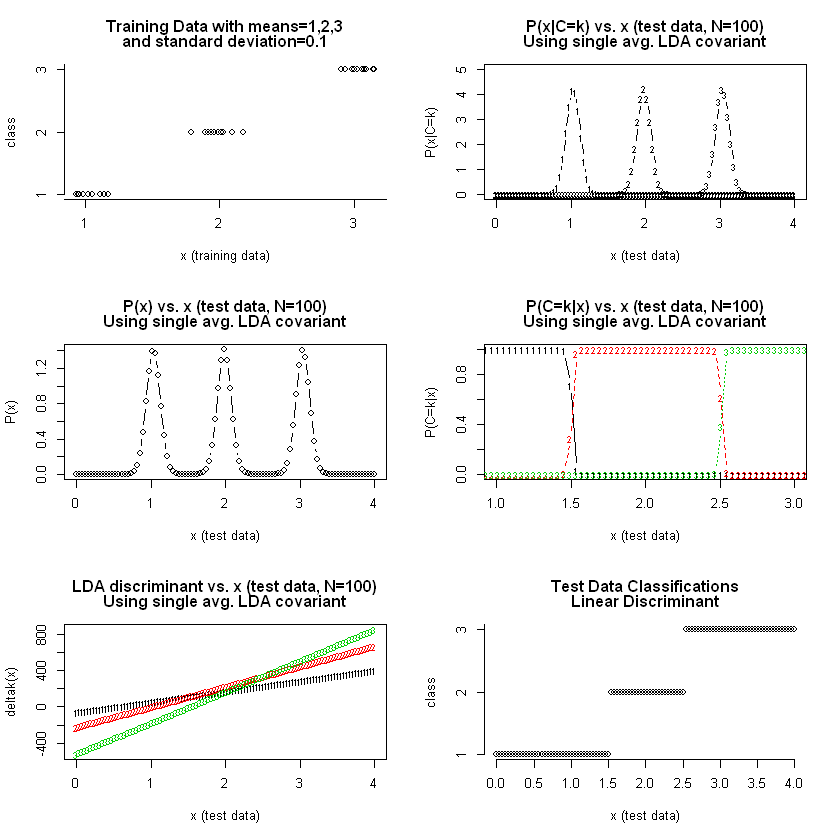

In [11]:
# plot the 1-D LDA results
plotLda_1d <- function(class_means=c(1, 2, 3), class_stdevs=c(0.1, 0.1, 0.1)) {
    # generate 3x2 plots for LDA evaluation
    par(mfrow=c(3,2))  # adjust as plots are added
    # generate and plot 1-D training data
    nclass <- length(class_means)
    xtrain <- getData1D(nclass, class_means, class_stdevs)
    plot1D_Training(xtrain)

    # generate sample 1-D test data
    xtest <- matrix(seq(0,4,len=100),100,1)
    Ntest <- length(xtest)

    # calculate priors and class means
    pc <- priorPofC(xtrain)
    muk <- classMeans(xtrain)
    # compute the average covariance matrix if data is 2 or more dimensions
    # single average variance value if data is 1 dimensional
    var <- AvgLdaCovar(xtrain)

    # generate some sample 1-D test data
    xtest <- matrix(seq(0,4,len=100),100,1)
    Ntest <- length(xtest)

    # calc & plot P(x|C=k) vs. x, start by eval'ing the first class
    pxc <- xtest
    pxc <- cbind(pxc, mydnormm(xtest, muk[1,], var))
    colnames(pxc)[] <- c("x", "pxc 1")
    plot(pxc[,1],pxc[,2],type="b", xlim=c(0,4), ylim=c(0,5),
         pch=paste(1), cex=0.7,
         main=c("P(x|C=k) vs. x (test data, N=100)",
         "Using single avg. LDA covariant"),
         xlab="x (test data)", ylab="P(x|C=k)")

    # now evaluate the remaining classes
    for(class in 2:nclass){
        #pxc <- cbind(pxc, data[which(data[,1]==class),2])
        pcalcs <- mydnormm(xtest,muk[class,], var)
        pxc <- cbind(pxc, pcalcs)
        colnames(pxc)[ncol(pxc)] <- paste("pxc", class)
        points(pxc[,1], pxc[,class+1], type="b",
             pch=paste(class), cex=0.7)
    }

    # calc & plot P(x) vs. x
    ptable <- cbind(pxc, rep(0,Ntest))  # init P(x) in last col
    pxcol <- ncol(ptable)               # set up P(x) column of values
    colnames(ptable)[pxcol] <- "pofx"
    for(class in 1:nclass)
        ptable[,pxcol] <- ptable[,pxcol]+(pxc[,class+1]*pc[class])

    plot(ptable[,1],ptable[,pxcol], type="b",
         main=c("P(x) vs. x (test data, N=100)",
         "Using single avg. LDA covariant"),
         xlab="x (test data)", ylab="P(x)")


    # calc & plot P(C|x) vs. x
    for(class in 1:nclass) {
        pcx <- ptable[,class+1] * pc[class] / ptable[,nclass+2]
        ptable <- cbind(ptable, pcx)
        colnames(ptable)[ncol(ptable)] <- paste("pcx", class)
    }
    pcx1col <- nclass + 3  # 1st 3 col's in ptable: P(X|C=1), P(X|C=2), P(X)
    pcxkcol <- pcx1col + (nclass - 1)  # col index for P(X|C=k) for k > 1
    matplot(ptable[,1],ptable[,pcx1col:pcxkcol], type="b", cex=0.7,
            main=c("P(C=k|x) vs. x (test data, N=100)",
            "Using single avg. LDA covariant"),
            xlim=c(1, 3), xlab="x (test data)", ylab="P(C=k|x)")


    # calc & plot little delta(x) LDA disciminant vs. x
    dx <- deltLda(xtest, Ntest, nclass, pc, muk, var)
    dx <- cbind(xtest,dx)
    matplot(dx[,1],dx[,2:ncol(dx)],cex=0.7,
            main=c("LDA discriminant vs. x (test data, N=100)",
            "Using single avg. LDA covariant"),
            xlab="x (test data)", ylab="deltak(x)")


    # do the LDA classification and plot the results
    classif <- dx
    classif <- cbind(classif, rep(0,nrow(classif)))
    colnames(classif) <- c("x", paste("dx", 1:nclass), "class")
    for(rw in 1:nrow(classif))
        classif[rw,ncol(classif)] <- which.max(classif[rw,2:(ncol(classif)-1)])

    plot(classif[,1],classif[,ncol(classif)],
         xlab="x (test data)",ylab="class",
         main=c("Test Data Classifications",
         "Linear Discriminant"), axes=FALSE)

    axis(1, seq(0,4,by=0.5))
    axis(2, 1:4)
}

plotLda_1d()

### 2-D QDA & LDA Visualizations On Synthetic Data

In this section we'll generate 2 datasets for each analysis: one nice and one naughty.  The plotting code used to generate the plots in this section has been considated into it's own source in order.  It's all checked into the repo if you want to see these details.

#### 2-D QDA On Nice Data

The first dataset will be *nice* meaning that it is seperable in 2-D space.  Notice the upper left plot.

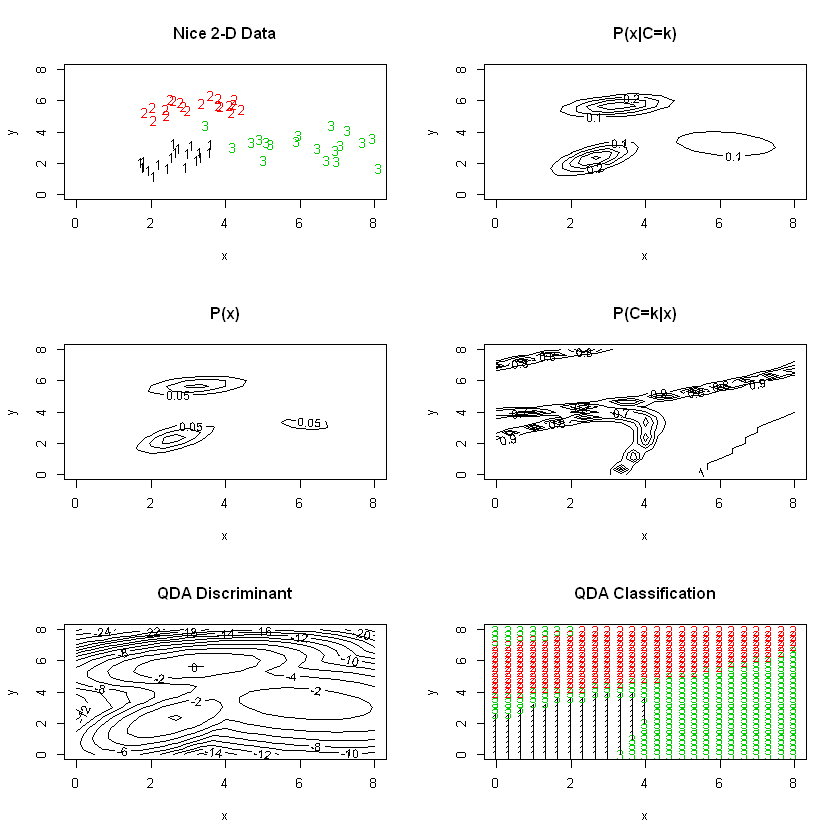

In [12]:
# The Qda2dPlotting.R source file needs function from QdaLda.R, so you may need to change
# the first source line in QdaLda2DPlots.R so it can find QdaLda.R
source('../../R/QdaLda2DPlots.R')  # assumes notebook running in ../WonderfulML/docs/solutions
plotQda_2d()

#### 2-D QDA On Naughty Data

Let's take a look at a data that is "naughty" (not seperable in 2-D).  Notice the overlapping of the class data in the plot in the upper left.

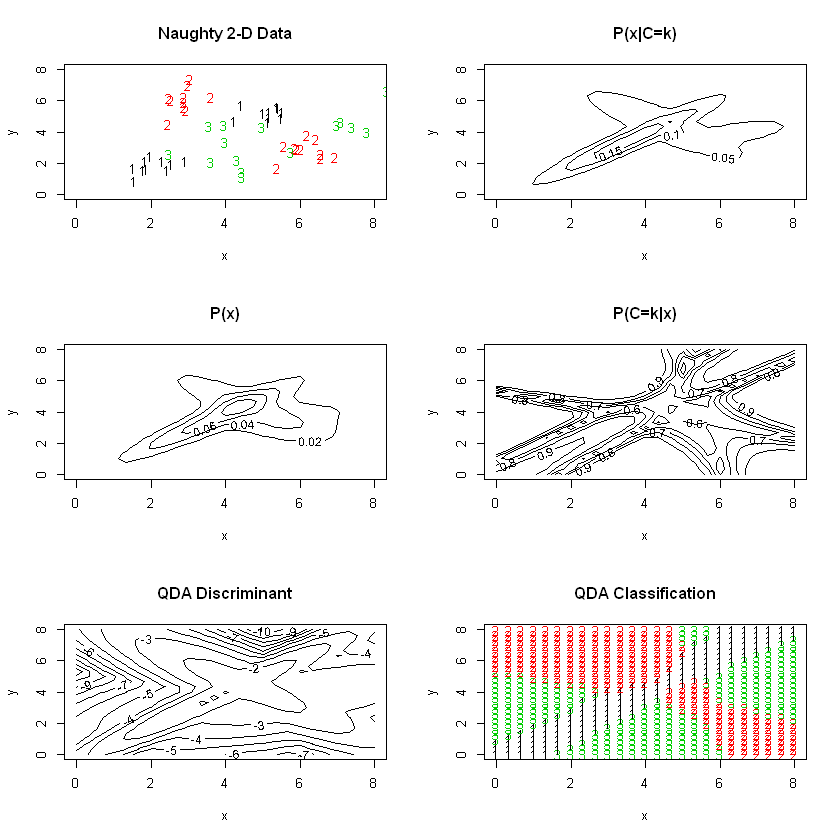

In [13]:
plotQda_2d(1)  # any number not 0 will be naughty data

#### 2-D LDA On Nice Data

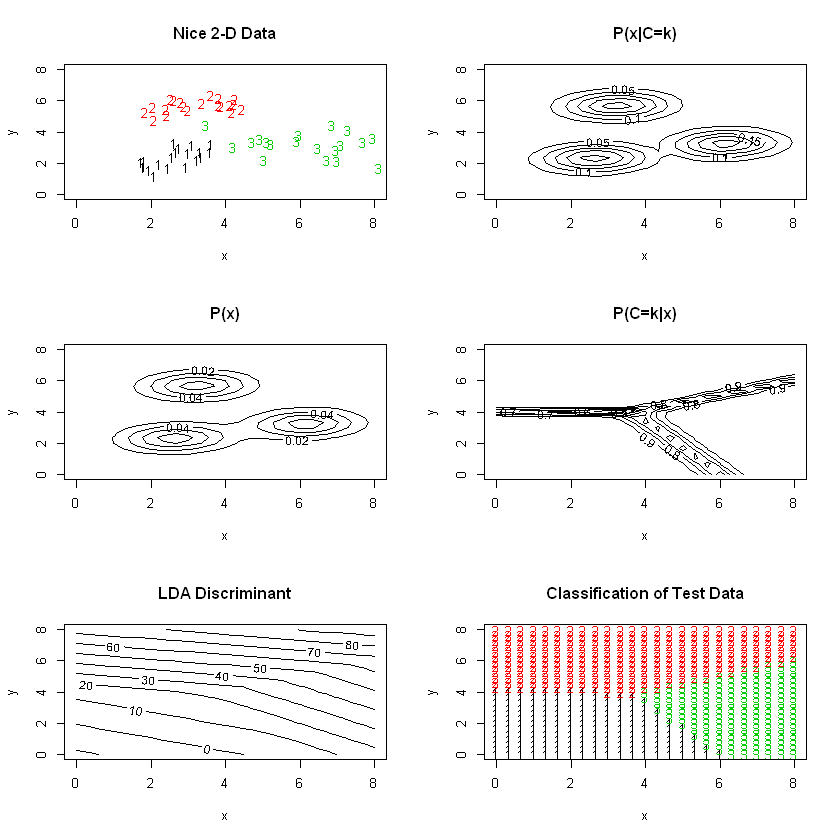

In [14]:
plotLda_2d()

#### 2-D LDA On Naughty Data

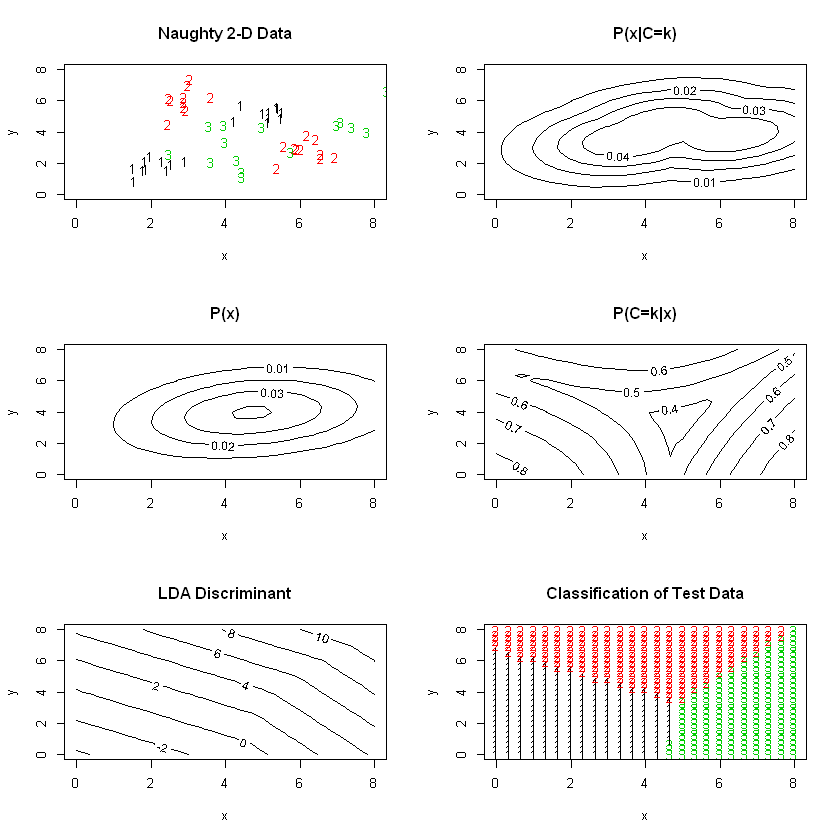

In [15]:
plotLda_2d(1)

### Applying LDA and QDA on Cleveland Heart Data (CHD)

In this section, we'll take our LDA and QDA models out for a spin on some real data.  The plots below shows the results of the 2-dimensional analysis of the CHD using LDA and QDA.  First, we need to do a little clean up of the data.  The last column (14) hold the targets designated 0-4.  As [described in the documentation](https://raw.githubusercontent.com/MichaelSzczepaniak/WonderfulML/master/data/cleveland_heart_disease_data_description.txt), 0 indicates no presence of heart disease, while values from 1 to 4 indicate varying degrees of heart disease.  To simply our analysis, we'll turn this into a binary classification problem and consider anything > 0 to indicate heart disease.

In the intrest of brevity, I'll skip over much of the details of the EDA so we can focus on the classification itself.  Of the 13 predictors in the abbreviated dataset, the following 8 variables didn't appear to have any significant effect on heart disease (**dhd** target variable):  2. sex, 3. cp, 6. fbs, 7. restecg, 9. exang, 11. slope, 12. ca, 13. thal.  The number preceding the original variable name is the column in the abbreviated dataset, (e.g. column 2 for *sex*).

A pairs plot of the remaining 5 predictors can be found [here](https://github.com/MichaelSzczepaniak/WonderfulML/raw/master/docs/graphics/chd_pairs_plot.jpg) and code used to create this plot can be found [here](https://raw.githubusercontent.com/MichaelSzczepaniak/WonderfulML/master/R/ClevelandHeartPairsPlot.R).  From the last last row of the pairs plot, the three factors that seemed to show some influence on **dhd** (renamed target variable, short for *detected heart disease*) were $\texttt{age}$, $\texttt{thalach}$ (abbreviated $\texttt{thlch}$), and $\texttt{oldpeak}$ (abbreviated $\texttt{oldpk}$). The $\texttt{age}$ and $\texttt{oldpk}$ factors to positively correlate to $\texttt{dhd}$, meaning that increases in these factors generally resulted in increase in $\texttt{dhd}$.  The factor $\texttt{thlch}$ appeared to correlate negatively.  From these observations, the three most prominant factors were reduces to two factors as follows:

$$
x_1 = \frac{\texttt{age}}{thlch}
$$
and
$$  
x_2 = \frac{\texttt{oldpk}+1}{(\texttt{thlch})}
$$

### LDA Results On Test Set

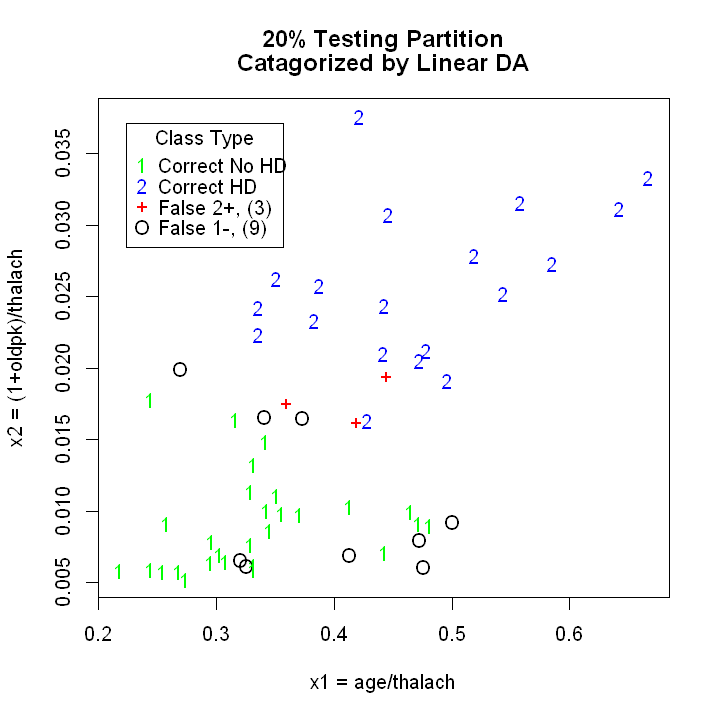

In [16]:
suppressMessages(suppressWarnings(library(repr)))
library(repr)
## Target column (dhd) is 14
dpath <- "https://raw.githubusercontent.com/MichaelSzczepaniak/WonderfulML/master/data/processed_cleveland_data.csv"
## Converts the 5 target categories in the CHD to 2: 1 = no heart disease, 2 = detected heart disease
makeChdBinaryCats <- function(data_file=dpath) {
    # read the original data
    clevdat <- read.table(data_file, sep=',')
    # clean up the data - remove rows with missing data
    keep.rows <- apply(clevdat != "?",1,all)
    clevdat <- clevdat[keep.rows,]
    # group target classifications - assign 0 to class 1,
    # assign 1-4 to class 2
    for(rw in 1:nrow(clevdat)) {
        if(clevdat[rw,14]==0)
            clevdat[rw,14] <- 1
        else if((clevdat[rw,3]==1)||(clevdat[rw,3] == 2))
            clevdat[rw,14] <- 2
        else if((clevdat[rw,3]==3)||(clevdat[rw,3] == 4))
            clevdat[rw,14] <- 2
    }
    
    # cull out vars I don't readily see a correl
    clevdat <- clevdat[,c(-2:-3,-6,-7,-9,-11:-13)]
    # rename remaining columns
    colnames(clevdat) <- c("age", "restbp", "chol", "thlch", "oldpk", "dhd")
    
    return(clevdat)
}

clev_dat <- makeChdBinaryCats()
# create engineered variables x1 and x2 as describe in previous cell
clev_dat <- cbind(clev_dat, clev_dat[,1]/clev_dat[,4])      # create and bind x1
colnames(clev_dat)[ncol(clev_dat)] <- "x1"
clev_dat <- cbind(clev_dat, (1+clev_dat[,5])/clev_dat[,4])  # create and bind x2
colnames(clev_dat)[ncol(clev_dat)] <- "x2"
            
# partition data into 80% training, 20% test
source('../../R/DataTools.R')  # for trainSetRows and testSetRows functions
train_rows <- trainSetRows(clev_dat, 0.8)
test_rows <- testSetRows(seq(1:nrow(clev_dat)), train_rows)
xtrain <- as.matrix(clev_dat[train_rows, 6:8]) # class in 1st col after operation
xtest_with_class <- as.matrix(clev_dat[test_rows,6:8])
xtest <- as.matrix(clev_dat[test_rows,7:8])  # class removed, use to make predictions

# compute 2D LDA discriminant parameters from training data
nclass <- length(unique(xtrain[,1]))  # should only be 2
pc <- priorPofC(xtrain)
muk <- classMeans(xtrain)
var <- AvgLdaCovar(xtrain)
# compute 2D LDA discriminant function on the test data
dx <- deltLda(xtest, Ntest, nclass, pc, muk, var)  # returns Nxd matrix
dx <- cbind(xtest_with_class, dx) # dhd, x1, x2, delta_class1(x), delta_class2(x)
# do the LDA classification and plot the results
classif <- dx
classif <- cbind(classif, rep(0,nrow(classif)))  # add 6th col to hold predicted class
classif <- cbind(classif, rep(0,nrow(classif)))  # add 7th col to hold plotting label
colnames(classif) <- c("dhd", "x1", "x2", paste("dx",1:nclass), "predicted_dhd", "plot_lab")
# structure of classif: dhd (actual class) in 1st col, x1 in 2nd col, x2 in 3rd col,
#                       delta_class1(x) in 4th col, delta_class2(x) in 5th col,
#                       6th col to be populated with predicted dhd,
#                       7th col to be populated with plotting label:
# 1=correctly classify no disease, 2=correctly classify disease,
# 3=classify disease but did NOT have disease (false positive, Type I error),
# 4=classify no disease, but had disease (false negative, Type II error)
symbols <- vector(mode = "character", length = nrow(classif))
symbol_colors <- vector(mode = "character", length = nrow(classif))
            confusion <- c(0, 0, 0, 0)
names(confusion) <- c("true_no_disease", "false_-_no_disease", "true_disease", "false_+_disease")
# Count the items for each cell of the confusion matrix
for(rw in 1:nrow(classif)) {
    # populate predicted class column by max of discriminants in cols 4 and 5 = ncol(classif)-2
    actual_class <- classif[rw, 1]
    predicted_class <- which.max(classif[rw, 4:(ncol(classif)-2)])
    classif[rw, ncol(classif)-1] <- predicted_class
    if(predicted_class > actual_class) { # test for false positive
        classif[rw, ncol(classif)] <- 3
        symbols[rw] <- "+"
        symbol_colors[rw] <- "red"
        confusion["false_+_disease"] <- confusion["false_+_disease"] + 1
    } else if(predicted_class < actual_class) { # test for false negative
        classif[rw, ncol(classif)] <- 4
        symbols[rw] <- "O"
        symbol_colors[rw] <- "black"
        confusion["false_-_no_disease"] <- confusion["false_-_no_disease"] + 1
    } else {
        # correct classification
        classif[rw, ncol(classif)] <- predicted_class
        if(predicted_class == 1) {
            symbols[rw] <- "1"
            symbol_colors[rw] <- "green"
            confusion["true_no_disease"] <- confusion["true_no_disease"] + 1
        } else {
            symbols[rw] <- "2"
            symbol_colors[rw] <- "blue"
            confusion["true_disease"] <- confusion["true_disease"] + 1
        }
    }
}

    
#symbol_colors
#head(classif, 10)

options(repr.plot.width=6, repr.plot.height=6)

plot(classif[, 2], classif[, 3], col=symbol_colors, pch=symbols,
     xlab="x1 = age/thalach", ylab="x2 = (1+oldpk)/thalach",
     main=c("20% Testing Partition", "Catagorized by Linear DA"))

legend("topleft", inset=0.05, title="Class Type", c("Correct No HD", "Correct HD", "False 2+, (3)", "False 1-, (9)"),
       pch=c("1", "2", "+", "O"), col=c("green", "blue", "red", "black"))

In [17]:
confusion_matrix = data.frame(has_disease=confusion[c("true_disease", "false_-_no_disease")],
                              no_disease=confusion[c("false_+_disease", "true_no_disease")])
rownames(confusion_matrix) <- c("diag_disease", "diag_no_disease")
confusion_matrix

,has_disease,no_disease
diag_disease,19,3
diag_no_disease,9,28


In [18]:
accuracy_lda <- (confusion_matrix[1,1] + confusion_matrix[2,2]) / sum(confusion)
accuracy_lda

[1] 0.7966102

### QDA Results On Test Set

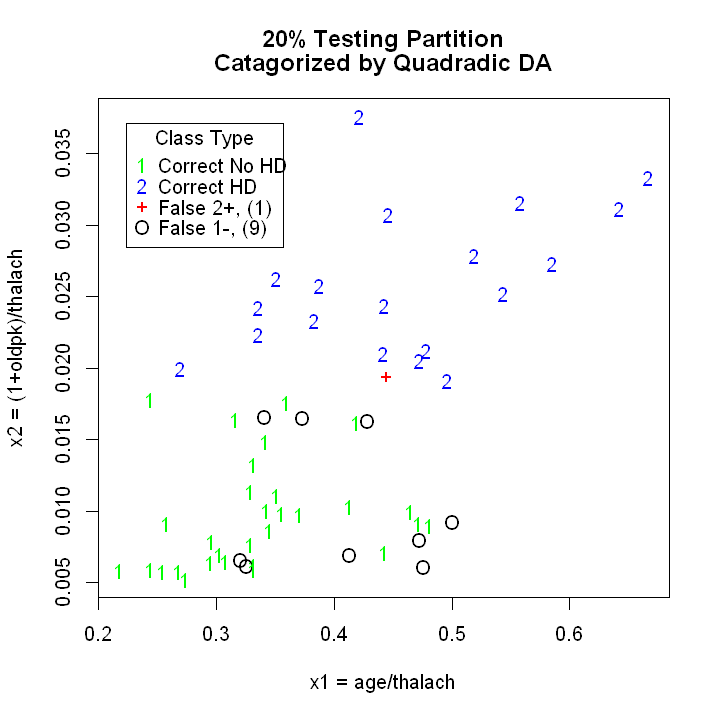

In [19]:
# compute 2D QDA discriminant parameters from training data
nclass <- length(unique(xtrain[,1]))  # should only be 2
pc <- priorPofC(xtrain)
muk <- classMeans(xtrain)
var <- classCovars(xtrain, muk)
# compute 2D QDA discriminant function on the test data
dx <- deltQda(xtest, Ntest, nclass, pc, muk, var)  # returns Nxd matrix
dx <- cbind(xtest_with_class, dx) # dhd, x1, x2, delta_class1(x), delta_class2(x)
# do the QDA classification and plot the results
classif <- dx
classif <- cbind(classif, rep(0,nrow(classif)))  # add 6th col to hold predicted class
classif <- cbind(classif, rep(0,nrow(classif)))  # add 7th col to hold plotting label
colnames(classif) <- c("dhd", "x1", "x2", paste("dx",1:nclass), "predicted_dhd", "plot_lab")
# structure of classif: dhd (actual class) in 1st col, x1 in 2nd col, x2 in 3rd col,
#                       delta_class1(x) in 4th col, delta_class2(x) in 5th col,
#                       6th col to be populated with predicted dhd,
#                       7th col to be populated with plotting label:
# 1=correctly classify no disease, 2=correctly classify disease,
# 3=classify disease but did NOT have disease (false positive, Type I error),
# 4=classify no disease, but had disease (false negative, Type II error)
symbols <- vector(mode = "character", length = nrow(classif))
symbol_colors <- vector(mode = "character", length = nrow(classif))
confusion <- c(0, 0, 0, 0)
names(confusion) <- c("true_no_disease", "false_-_no_disease", "true_disease", "false_+_disease")
# process confusion matrix related parameters
for(rw in 1:nrow(classif)) {
    # populate predicted class column by max of discriminants in cols 4 and 5 = ncol(classif)-2
    actual_class <- classif[rw, 1]
    predicted_class <- which.max(classif[rw, 4:(ncol(classif)-2)])
    classif[rw, ncol(classif)-1] <- predicted_class
    if(predicted_class > actual_class) { # test for false positive
        classif[rw, ncol(classif)] <- 3
        symbols[rw] <- "+"
        symbol_colors[rw] <- "red"
        confusion["false_+_disease"] <- confusion["false_+_disease"] + 1
    } else if(predicted_class < actual_class) { # test for false negative
        classif[rw, ncol(classif)] <- 4
        symbols[rw] <- "O"
        symbol_colors[rw] <- "black"
        confusion["false_-_no_disease"] <- confusion["false_-_no_disease"] + 1
    } else {
        # correct classification
        classif[rw, ncol(classif)] <- predicted_class
        if(predicted_class == 1) {
            symbols[rw] <- "1"
            symbol_colors[rw] <- "green"
            confusion["true_no_disease"] <- confusion["true_no_disease"] + 1
        } else {
            symbols[rw] <- "2"
            symbol_colors[rw] <- "blue"
            confusion["true_disease"] <- confusion["true_disease"] + 1
        }
    }
}

    
#symbol_colors
#head(classif, 10)

options(repr.plot.width=6, repr.plot.height=6)

plot(classif[, 2], classif[, 3], col=symbol_colors, pch=symbols,
     xlab="x1 = age/thalach", ylab="x2 = (1+oldpk)/thalach",
     main=c("20% Testing Partition", "Catagorized by Quadradic DA"))

legend("topleft", inset=0.05, title="Class Type", c("Correct No HD", "Correct HD", "False 2+, (1)", "False 1-, (9)"),
       pch=c("1", "2", "+", "O"), col=c("green", "blue", "red", "black"))

In [22]:
confusion_matrix = data.frame(has_disease=confusion[c("true_disease", "false_-_no_disease")],
                              no_disease=confusion[c("false_+_disease", "true_no_disease")])
rownames(confusion_matrix) <- c("diag_disease", "diag_no_disease")
confusion_matrix

,has_disease,no_disease
diag_disease,19,1
diag_no_disease,9,30


In [23]:
accuracy_qda <- (confusion_matrix[1,1] + confusion_matrix[2,2]) / sum(confusion)
accuracy_qda

[1] 0.8305085

### References

1. Wickham, Hadley, *Tidy Data*, Journal of Statistical Software, August 2014, Volume 59, Issue 10. [https://www.jstatsoft.org/article/view/v059i10/v59i10.pdf](https://www.jstatsoft.org/article/view/v059i10/v59i10.pdf)
2. Hadley Wickham's "dplyr" tutorial at useR 2014 (1/2) [https://www.youtube.com/watch?v=8SGif63VW6E](https://www.youtube.com/watch?v=8SGif63VW6E)
3. Hadley Wickham's "dplyr" tutorial at useR 2014 (2/2) [https://www.youtube.com/watch?v=Ue08LVuk790](https://www.youtube.com/watch?v=Ue08LVuk790)
4. Data sets for the 2014 dplyr tutorial, [https://www.dropbox.com/sh/i8qnluwmuieicxc/AAAgt9tIKoIm7WZKIyK25lh6a](https://www.dropbox.com/sh/i8qnluwmuieicxc/AAAgt9tIKoIm7WZKIyK25lh6a)